15% of customers churn are coming from international plan. 
The VP of Marketing added that churn appears higher among customers with monthly contracts

1. Data Analysis: Conduct a thorough examination of customer data to identify patterns
and trends contributing to churn. Use this analysis to validate or disprove the
assumptions made by the board.
2. Predictive Modeling: Build machine learning models to predict which customers are
most at risk of churning, allowing the company to take preemptive action.
3. Strategic Insights: Provide the executive team with actionable recommendations
based on your findings. These recommendations will form the foundation for customer
retention campaigns and operational changes.

Instructions
1. Download the Dataset: Use the Telecom Churn Dataset from here:
2. Complete All Tasks: Follow the tasks outlined below step-by-step.
3. Prepare Files for Submission: Submit your work as a ZIP file named:
StudentNumber_ Churn_Assignment.zip. This ZIP file should contain:
o A Jupyter Notebook file (StudentNumber_Churn_Notebook.ipynb).
o A trained model saved as a Pickle file (StudentNumber_Model.pkl).
4. Upload to Moodle: Submit the ZIP file on Moodle under the appropriate assignment
link before the deadline.

##  Q1 The CEO claims that 15% of customers churn are coming from international plan . Using the provided dataset validate the CEO’s statement and extract additional insights. (In the submitted notebook you should clearly state all the steps done to answer the questions)

### Q1.1 – Is the CEO statement correct? [Yes, No] If not, what is the churn percentage? [Numeric] 1 points

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Import the dataset as a CSV
df = pd.read_csv('2767ML_assignment1_data.csv')
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,NE,64,408,No,No,0,261.9,113,44.52,148.1,99,12.59,145.2,74,6.53,13.8,4,3.73,0,False
1,TX,139,510,Yes,Yes,31,203.5,82,34.60,200.3,72,17.03,214.0,112,9.63,13.4,6,3.62,1,True
2,VT,93,510,No,No,0,190.7,114,32.42,218.2,111,18.55,129.6,121,5.83,8.1,3,2.19,3,False
3,GA,136,415,No,No,0,163.4,83,27.78,249.3,119,21.19,249.7,90,11.24,9.8,4,2.65,7,False
4,IL,16,415,Yes,No,0,110.0,91,18.70,147.3,75,12.52,190.5,73,8.57,6.4,7,1.73,0,False


In [2]:
# Show summary statistics for all columns
df.describe()

,Account length,Area code,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
count,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000
mean,101.348449,436.735245,8.194065,179.796132,100.572858,30.565895,201.225375,100.136379,17.104365,201.064688,100.077026,9.048006,10.209003,4.474825,2.756939,1.566522
std,39.741765,42.112741,13.731450,54.313911,20.100779,9.233338,50.952796,20.076914,4.330967,50.610602,19.485898,2.277532,2.772336,2.471441,0.748525,1.327655
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,88.000000,24.430000,166.550000,87.000000,14.155000,167.250000,87.000000,7.525000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.300000,101.000000,30.480000,201.800000,101.000000,17.150000,201.600000,100.000000,9.070000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,415.000000,20.000000,216.850000,114.000000,36.865000,235.450000,114.000000,20.015000,235.300000,113.000000,10.590000,12.000000,6.000000,3.240000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,18.900000,20.000000,5.100000,9.000000


In [3]:
# check for null values
df.isnull().sum()
# no null values, so no need to drop any rows

State                     0
Account length            0
Area code                 0
International plan        0
Voice mail plan           0
Number vmail messages     0
Total day minutes         0
Total day calls           0
Total day charge          0
Total eve minutes         0
Total eve calls           0
Total eve charge          0
Total night minutes       0
Total night calls         0
Total night charge        0
Total intl minutes        0
Total intl calls          0
Total intl charge         0
Customer service calls    0
Churn                     0
dtype: int64

In [4]:
# check for duplicate rows
duplicates = df.duplicated().sum()
print(f"Number of Duplicate Rows:{duplicates}")
# no duplicate rows, so no need to drop any rows

Number of Duplicate Rows:0


In [5]:
#Check variables and associated data type
df.dtypes
# Looks fine as well

State                      object
Account length              int64
Area code                   int64
International plan         object
Voice mail plan            object
Number vmail messages       int64
Total day minutes         float64
Total day calls             int64
Total day charge          float64
Total eve minutes         float64
Total eve calls             int64
Total eve charge          float64
Total night minutes       float64
Total night calls           int64
Total night charge        float64
Total intl minutes        float64
Total intl calls            int64
Total intl charge         float64
Customer service calls      int64
Churn                        bool
dtype: object

In [6]:
# Finding out if 15% of customers churn are coming from international plan
# Filtering to only show churned customers
churned = df[df['Churn'] == True]
churned.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
1,TX,139,510,Yes,Yes,31,203.5,82,34.60,200.3,72,17.03,214.0,112,9.63,13.4,6,3.62,1,True
5,IN,65,415,No,No,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4,True
6,OK,101,408,No,No,0,89.7,118,15.25,260.1,79,22.11,170.1,93,7.65,13.5,11,3.65,5,True
12,CO,92,415,No,No,0,184.7,60,31.40,262.0,73,22.27,239.5,120,10.78,12.3,6,3.32,2,True
13,WA,55,408,No,No,0,285.7,124,48.57,230.9,106,19.63,230.7,140,10.38,14.8,7,4.00,0,True


In [7]:
# Printing out the total number of churned customers
nr_churned = churned.shape[0]
print(f"There are {nr_churned} churned customers")
# Printing out the total number of churned customers with International Plan
nr_churned_international = churned[churned['International plan'] == 'Yes'].shape[0]
print(f"There are {nr_churned_international} churned customers with International Plan")
# Printing out the percentage of churned customers with International Plan
percentage = (nr_churned_international / nr_churned) * 100
print(f"{percentage}% of churned customers have an International Plan")
print("Therefore, the CEO's claim that 15% of customers churn are coming from the international plan is not correct")

There are 435 churned customers
There are 120 churned customers with International Plan
27.586206896551722% of churned customers have an International Plan
Therefore, the CEO's claim that 15% of customers churn are coming from the international plan is not correct


### Q1.2 Provide three insights you extracted from the EDA analysis

In [8]:
# Insight 1: Finding out proportion of customers who have churned in total
total_churned = df['Churn'].sum()
total_customers = df.shape[0]
proportion = (total_churned / total_customers) * 100
print(f"Insight 1: {proportion}% of customers have churned in total")

Insight 1: 14.50483494498166% of customers have churned in total


This means the dataset is unbalanced and we need to be careful building the model so it can predict both churners and non-churners well

In [9]:
# Insight 2: Finding out if churned customers have higher customer service calls than non-churned customers
non_churned = df[df['Churn'] == False]

avg_service_calls_churned = churned['Customer service calls'].mean()
avg_service_calls_non_churned = non_churned['Customer service calls'].mean()

print(f"Average customer service calls for churned customers: {avg_service_calls_churned}")
print(f"Average customer service calls for non-churned customers: {avg_service_calls_non_churned}")

if avg_service_calls_churned > avg_service_calls_non_churned:
    print("Insight 2: Churned customers have higher average nr. of customer service calls than non-churned customers.")
else:
    print("Insight 2: Churned customers do not have higher average nr. of customer service calls than non-churned customers.")


Average customer service calls for churned customers: 2.2666666666666666
Average customer service calls for non-churned customers: 1.4477379095163807
Insight 2: Churned customers have higher average nr. of customer service calls than non-churned customers.


In [10]:
#Insight 3: Find out if customers who were charged more than the average monthly charge are more likely to churn
# Adding column that sums up total day charge, total eve charge, total night charge and total intl charge
insight_3_df = df.copy()
insight_3_df['Total charge'] = insight_3_df['Total day charge'] + insight_3_df['Total eve charge'] + insight_3_df['Total night charge'] + insight_3_df['Total intl charge']
insight_3_df["Total charge"].describe()

count    2999.000000
mean       59.475205
std        10.446254
min        22.930000
25%        52.460000
50%        59.510000
75%        66.475000
max        96.150000
Name: Total charge, dtype: float64

In [11]:
# Calculating likelihood of churn for customers who were charged more than the average monthly charge
# Calculate average charge
avg_charge = insight_3_df['Total charge'].mean()
# Extracting churned customers who were charged more than the average monthly charge
churned_above_avg_charge = insight_3_df[insight_3_df['Total charge'] > avg_charge]
churned_above_avg_charge.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,...,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn,Total charge
0,NE,64,408,No,No,0,261.9,113,44.52,148.1,...,12.59,145.2,74,6.53,13.8,4,3.73,0,False,67.37
1,TX,139,510,Yes,Yes,31,203.5,82,34.60,200.3,...,17.03,214.0,112,9.63,13.4,6,3.62,1,True,64.88
3,GA,136,415,No,No,0,163.4,83,27.78,249.3,...,21.19,249.7,90,11.24,9.8,4,2.65,7,False,62.86
7,TN,47,415,No,Yes,30,196.6,93,33.42,241.4,...,20.52,226.0,118,10.17,12.9,4,3.48,2,False,67.59
8,NE,73,415,No,No,0,198.3,94,33.71,279.3,...,23.74,146.2,87,6.58,14.8,8,4.00,3,False,68.03


In [12]:
# Calculate churn rate for customers who were charged more than the average monthly charge
churn_rate_above_avg_charge = churned_above_avg_charge['Churn'].mean() * 100
print(f"The churn rate for customers who were charged more than the average monthly charge is {churn_rate_above_avg_charge}%")
#Calculate average churn rate for all customers
avg_churn_rate = insight_3_df['Churn'].mean() * 100
print(f"The average churn rate for all customers is {avg_churn_rate}%")
print(f"Insight 3: Customers who were charged more than the average monthly charge are more likely to churn than the average customer")

The churn rate for customers who were charged more than the average monthly charge is 17.154255319148938%
The average churn rate for all customers is 14.50483494498166%
Insight 3: Customers who were charged more than the average monthly charge are more likely to churn than the average customer


## Q2 The executive team needs a robust predictive solution to identify customers most at risk of churning. Machine learning models can provide the insights required for targeted retention strategies.

### Q2.1 Which kind of machine learning problem is Telecom facing? [Multiple choice, regression, classification, recommendation systems, foundational model]

This is a classification problem because the target variable/label "Churn" is a binary variable that takes on one of two possible values, namely "True" or "False"

### Q2.2 Train two models that are adecuated to the problem. Justify why you chose those. [Free text + code] In the code document the hyperparamenter tunning, train test split and all the processing steps

#### Model 1: Logistic Regression

This model is chosen because Logistic regression is a simple classification algorithm that can predict the probability of a binary response belonging to one class or the other. This is exactly the kind of prediction problem we have for our dataset where we predict if a customer churns or not.

##### Step 1: Feature Selection

In [13]:
# Model 1: Logistic Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Selection
# Drop state column as it is a categorical variable with too many options to be included in the model
model1_df = df.drop('State', axis=1)
# Make categorical columns International Plan and Voice Mail Plan into binary columns with 1 for Yes and 0 for No, do the same for Churn
model1_df['International plan'] = model1_df['International plan'].map({'Yes': 1, 'No': 0})
model1_df['Voice mail plan'] = model1_df['Voice mail plan'].map({'Yes': 1, 'No': 0})
model1_df['Churn'] = model1_df['Churn'].astype(int)
model1_df.head()

,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,64,408,0,0,0,261.9,113,44.52,148.1,99,12.59,145.2,74,6.53,13.8,4,3.73,0,0
1,139,510,1,1,31,203.5,82,34.60,200.3,72,17.03,214.0,112,9.63,13.4,6,3.62,1,1
2,93,510,0,0,0,190.7,114,32.42,218.2,111,18.55,129.6,121,5.83,8.1,3,2.19,3,0
3,136,415,0,0,0,163.4,83,27.78,249.3,119,21.19,249.7,90,11.24,9.8,4,2.65,7,0
4,16,415,1,0,0,110.0,91,18.70,147.3,75,12.52,190.5,73,8.57,6.4,7,1.73,0,0


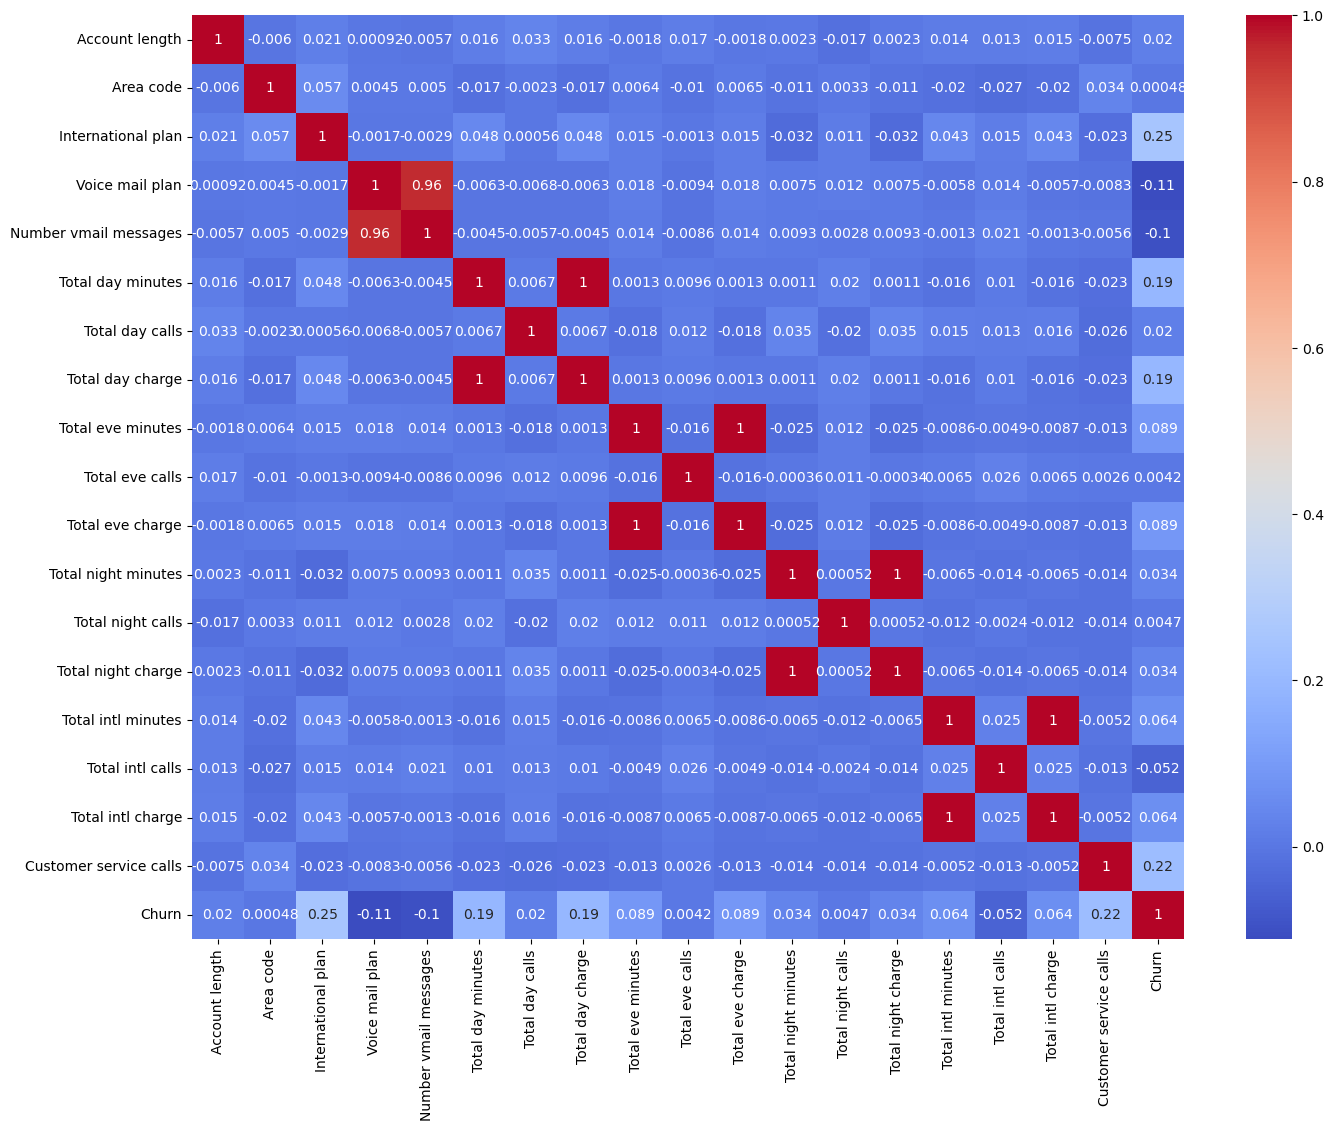

In [14]:
# Look at the correlation matrix to see which variables are correlated with Churn and should be included in the model
plt.figure(figsize=(16, 12))
sns.heatmap(model1_df.corr(), annot=True, cmap='coolwarm')
plt.show()

In [15]:
# As total eve calls is perfectly correlated with total eve charge and total eve minutes, we will drop total eve calls and total eve minutes to avoid multicollinearity
model1_df = model1_df.drop(['Total eve calls', 'Total eve minutes'], axis=1)
# Do the same for total day calls and total day minutes, total night calls and total night minutesm as well as total intl calls and total intl minutes
model1_df = model1_df.drop(['Total day calls', 'Total day minutes', 'Total night calls', 'Total night minutes', 'Total intl calls', 'Total intl minutes'], axis=1)
# Also drop area code column as it barely correlates with churn and should also be categorical, not numerical
model1_df = model1_df.drop('Area code', axis=1)
model1_df.head()

,Account length,International plan,Voice mail plan,Number vmail messages,Total day charge,Total eve charge,Total night charge,Total intl charge,Customer service calls,Churn
0,64,0,0,0,44.52,12.59,6.53,3.73,0,0
1,139,1,1,31,34.60,17.03,9.63,3.62,1,1
2,93,0,0,0,32.42,18.55,5.83,2.19,3,0
3,136,0,0,0,27.78,21.19,11.24,2.65,7,0
4,16,1,0,0,18.70,12.52,8.57,1.73,0,0


In [16]:
# As Number vmail messages is very highly correlated with Voice mail plan_Yes and Number vmail messages contains
# more information, we will drop Voice mail plan_Yes to avoid multicollinearity
model1_df = model1_df.drop(['Voice mail plan'], axis=1)
model1_df.head()

,Account length,International plan,Number vmail messages,Total day charge,Total eve charge,Total night charge,Total intl charge,Customer service calls,Churn
0,64,0,0,44.52,12.59,6.53,3.73,0,0
1,139,1,31,34.60,17.03,9.63,3.62,1,1
2,93,0,0,32.42,18.55,5.83,2.19,3,0
3,136,0,0,27.78,21.19,11.24,2.65,7,0
4,16,1,0,18.70,12.52,8.57,1.73,0,0


In [17]:
# Creating a descriptive table with min, median, mean, max values for the numerical columns
model1_df.describe()

,Account length,International plan,Number vmail messages,Total day charge,Total eve charge,Total night charge,Total intl charge,Customer service calls,Churn
count,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000
mean,101.348449,0.096032,8.194065,30.565895,17.104365,9.048006,2.756939,1.566522,0.145048
std,39.741765,0.294684,13.731450,9.233338,4.330967,2.277532,0.748525,1.327655,0.352208
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.040000,0.000000,0.000000,0.000000
25%,74.000000,0.000000,0.000000,24.430000,14.155000,7.525000,2.300000,1.000000,0.000000
50%,101.000000,0.000000,0.000000,30.480000,17.150000,9.070000,2.780000,1.000000,0.000000
75%,127.000000,0.000000,20.000000,36.865000,20.015000,10.590000,3.240000,2.000000,0.000000
max,243.000000,1.000000,51.000000,59.640000,30.910000,17.770000,5.100000,9.000000,1.000000


##### Step 2: Train-test split

In [18]:
# Splitting the data into training and testing sets (80/20 split)
X = model1_df.drop(['Churn'], axis=1)  # Features
y = model1_df['Churn']  # Target variable

# Using stratify=y to ensure that the train and test sets have approximately the same proportion of churn instances
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check the shapes of the train and test sets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Check the distribution of the target variable in train and test sets to ensure that stratify=y worked
print(f"Churn rate in training set: {y_train.mean() * 100:.2f}%")
print(f"Churn rate in test set: {y_test.mean() * 100:.2f}%")

X_train shape: (2399, 8)
X_test shape: (600, 8)
y_train shape: (2399,)
y_test shape: (600,)
Churn rate in training set: 14.51%
Churn rate in test set: 14.50%


##### Step 3: Hyperparameter tuning

In [19]:
# For logistic regression, a suitable hyperparameter is the lambda parameter for regularization
# Use of ElasticNetCV to find the optimal lambda parameter
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import StratifiedKFold

# We will add stratified cross-validation to properly handle the class imbalance

# Create a stratified cross-validation object to split the data in a way
# that preserves the percentage of samples for each class
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Alphas and l1_ratio parameters to search
alphas = [0.0001, 0.001, .01, .1, 1, 10, 100]
l1_ratios = [0.0001, .001, .01, .1, .2, .4, .8, .99, .999, 1]

# Create ElasticNetCV object with stratified cross-validation
elastic_net = ElasticNetCV(
    l1_ratio=l1_ratios,
    alphas=alphas,
    cv=cv,
    random_state=42,
    selection='random'  # For faster computation
)
# Fit the model to the training data
elastic_net.fit(X_train, y_train)

# Print the optimal l1_ratio parameter
print(f"Optimal l1_ratio parameter: {elastic_net.l1_ratio_}")
print(f"A l1_ratio of {elastic_net.l1_ratio_} means that the optimal model uses more L2 regularization than L1 regularization, so it tries to set some coefficients to zero.")

# Print the optimal lambda parameter
print(f"\nOptimal lambda parameter: {elastic_net.alpha_}")
print(f"A lambda parameter of {elastic_net.alpha_} means that the optimal model only penalizes the coefficients slightly, so it does not use much regularization.")
print("This makes sense as we have already removed highly correlated variables and have a small number of features.")

Optimal l1_ratio parameter: 0.0001
A l1_ratio of 0.0001 means that the optimal model uses more L2 regularization than L1 regularization, so it tries to set some coefficients to zero.

Optimal lambda parameter: 0.001
A lambda parameter of 0.001 means that the optimal model only penalizes the coefficients slightly, so it does not use much regularization.
This makes sense as we have already removed highly correlated variables and have a small number of features.


One further parameter to change is the decision threshhold, however, this is not a hyperparameter in the strictest  sense as it does not impact the model's training process. We will use the default decision threshold of 0.5 and try different thresholds later on

##### Step 4: Training the Model

In [20]:
# Training the logistic regression model on the test-split of the data
log_reg = LogisticRegression(penalty='elasticnet', l1_ratio=elastic_net.l1_ratio_, C=1/elastic_net.alpha_, solver='saga', random_state=42)
log_reg.fit(X_train, y_train)

# Making predictions on the test set
y_pred = log_reg.predict(X_test)

c:\Users\vicedeputy\miniconda3\envs\ML\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


##### Step 5: Evaluating the base model

In [21]:
from sklearn.metrics import recall_score

# Calculate the accuracy of the model on the test set
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the logistic regression model: {accuracy * 100:.2f}%")

# Also calculate the recall of the model on the test set because when predicting churn, we want to minimize false negatives
recall = recall_score(y_test, y_pred)
print(f"Recall of the logistic regression model: {recall * 100:.2f}%")

Accuracy of the logistic regression model: 85.50%
Recall of the logistic regression model: 2.30%


In [22]:
# Show some examples of correct predictions including the actual and predicted churn values
# Create a DataFrame with test data and add columns for actual and predicted values plus their percentage certainties
correct_pred_df = X_test.copy()

correct_pred_df['Actual_Churn'] = y_test
correct_pred_df['Predicted_Churn'] = y_pred

# Add probability predictions (certainty percentages) using predict_proba which returns the probability of each class
# In the case of a 2-class problem, it will use the sigmoid function to calculate the probability of the positive class
y_pred_proba = log_reg.predict_proba(X_test)
correct_pred_df['Probability_Positive_Class'] = [prob[1] * 100 for prob in y_pred_proba]

# Filter for correct predictions
correct_pred_df = correct_pred_df[correct_pred_df['Actual_Churn'] == correct_pred_df['Predicted_Churn']]

# Print nr of correct predictions
print(f"Number of correct predictions: {correct_pred_df.shape[0]}")
print(f"Percentage of correct predictions: {correct_pred_df.shape[0] / len(y_test) * 100:.2f}%")

# Display a few examples of correct predictions
print("\nExamples of correct predictions:")
correct_pred_df.head(10)

Number of correct predictions: 513
Percentage of correct predictions: 85.50%

Examples of correct predictions:


,Account length,International plan,Number vmail messages,Total day charge,Total eve charge,Total night charge,Total intl charge,Customer service calls,Actual_Churn,Predicted_Churn,Probability_Positive_Class
694,132,0,0,14.18,19.74,6.60,2.05,1,0,0,11.536749
2644,31,0,28,35.79,21.29,10.87,3.11,1,0,0,7.398511
596,80,0,0,25.26,17.92,9.17,2.70,2,0,0,18.077609
2423,95,0,0,26.84,22.07,10.35,3.78,0,0,0,7.026890
1389,115,0,0,34.03,20.82,8.59,2.38,1,0,0,14.221253
1011,205,0,24,29.89,13.18,8.13,2.11,2,0,0,7.387977
484,67,0,0,25.93,21.45,8.34,1.32,2,0,0,22.281113
2078,86,0,0,33.01,16.47,8.64,2.51,3,0,0,28.107490
1338,105,0,0,36.04,19.26,8.71,2.40,3,0,0,25.472679
170,41,0,41,35.24,11.67,5.21,1.59,1,0,0,14.254927


In [23]:
# Show some examples of incorrect predictions including the actual and predicted churn values
# Create a DataFrame with test data and add columns for actual and predicted values
incorrect_pred_df = X_test.copy()
incorrect_pred_df['Actual_Churn'] = y_test
incorrect_pred_df['Predicted_Churn'] = y_pred

# Add probability predictions (certainty percentages) using predict_proba which returns the probability of each class
# In the case of a 2-class problem, it will use the sigmoid function to calculate the probability of the positive class
y_pred_proba = log_reg.predict_proba(X_test)
incorrect_pred_df['Probability_Positive_Class'] = [prob[1] * 100 for prob in y_pred_proba]

# Filter for incorrect predictions
incorrect_pred_df = incorrect_pred_df[incorrect_pred_df['Actual_Churn'] != incorrect_pred_df['Predicted_Churn']]
# Print nr of incorrect predictions
print(f"Number of incorrect predictions: {incorrect_pred_df.shape[0]}")
print(f"Percentage of incorrect predictions: {incorrect_pred_df.shape[0] / len(y_test) * 100:.2f}%")

# Display a few examples of incorrect predictions
print("\nExamples of incorrect predictions:")
incorrect_pred_df.head(10)

Number of incorrect predictions: 87
Percentage of incorrect predictions: 14.50%

Examples of incorrect predictions:


,Account length,International plan,Number vmail messages,Total day charge,Total eve charge,Total night charge,Total intl charge,Customer service calls,Actual_Churn,Predicted_Churn,Probability_Positive_Class
276,101,0,36,21.03,14.67,12.62,2.38,1,1,0,3.248281
2726,66,0,0,28.44,19.55,8.63,2.86,1,1,0,15.927910
284,107,0,0,50.13,16.39,6.66,3.56,1,1,0,23.678510
817,68,1,29,33.24,14.59,9.18,3.65,1,1,0,9.214135
2425,75,0,0,18.53,22.04,8.19,3.59,4,1,0,22.833879
2860,81,1,0,25.40,14.61,9.65,4.83,3,1,0,21.826162
2625,117,0,0,20.13,21.19,10.22,3.67,5,1,0,20.491161
1333,50,0,0,22.29,13.64,9.31,1.51,5,1,0,44.401957
919,93,1,38,38.37,10.17,8.69,3.78,1,1,0,8.262952
2478,111,0,0,48.35,13.35,10.93,2.27,0,1,0,15.137555


In [24]:
# Display confusion matrix for the logistic regression model
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a DataFrame to display the confusion matrix
conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual Not Churned', 'Actual Churned'], columns=['Predicted Not Churned', 'Predicted Churned'])

# Display the confusion matrix
conf_matrix_df

,Predicted Not Churned,Predicted Churned
Actual Not Churned,511,2
Actual Churned,85,2


Problem with the model: it predicts almost all customers not to churn and therefore there is no good indication it can even predict a customer to churn. This makes this model pretty useless for our business case. 

We can find a better decision threshold by examining the ROC curve to balance recall and false positive rate, then choosing a threshold that produces a better accuracy

##### Step 6: Choosing the right decision threshold

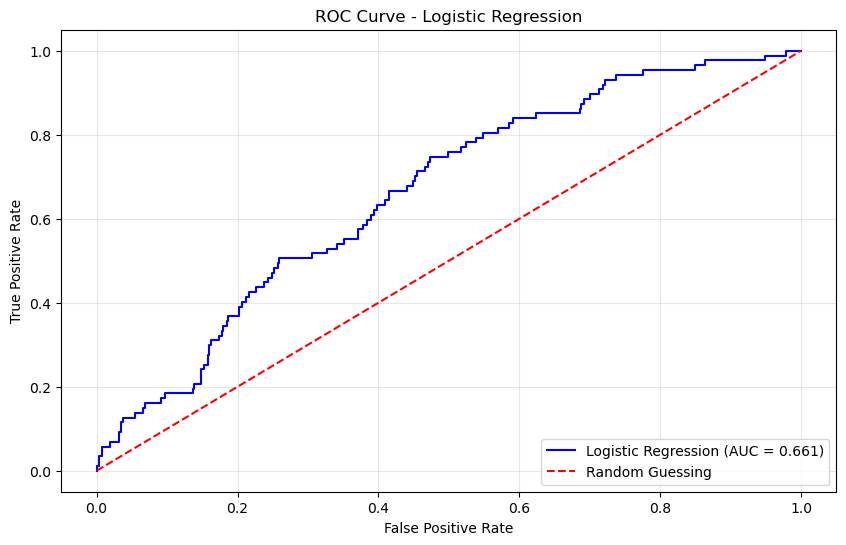

AUC Score: 0.661
Number of possible threshold points: 153


In [25]:
# Create ROC curve for the logistic regression model
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate the FPR, TPR, and thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_proba[:, 1])

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'Logistic Regression (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.grid(True, alpha=0.3)
plt.legend(loc='lower right')
plt.show()

# Print additional information about the ROC curve
print(f"AUC Score: {auc_score:.3f}")
# Print the number of threshold points (equal to the number of unique probabilities of probability outputs of the model)
print(f"Number of possible threshold points: {len(thresholds)}")

In [26]:
# Extract TP, TN, FP, and FN from the confusion matrix
TP = conf_matrix_df.loc['Actual Churned', 'Predicted Churned']
TN = conf_matrix_df.loc['Actual Not Churned', 'Predicted Not Churned']
FP = conf_matrix_df.loc['Actual Not Churned', 'Predicted Churned']
FN = conf_matrix_df.loc['Actual Churned', 'Predicted Not Churned']

# Create a dataframe containing the top 15 thresholds ranked by highest accuracy
accuracy_df = pd.DataFrame()

# Create a new dataframe to store threshold and accuracy
accuracy_values = []

for threshold in thresholds:
    # Predict using the current threshold
    y_pred_threshold = [True if prob[1] >= threshold else False for prob in y_pred_proba]
    
    # Calculate TP, TN, FP, FN for this threshold
    TP = sum((a == True) and (p == True) for a, p in zip(y_test, y_pred_threshold))
    TN = sum((a == False) and (p == False) for a, p in zip(y_test, y_pred_threshold))
    FP = sum((a == False) and (p == True) for a, p in zip(y_test, y_pred_threshold))
    FN = sum((a == True) and (p == False) for a, p in zip(y_test, y_pred_threshold))
    
    # Calculate accuracy
    current_accuracy = (TP + TN) / (TP + TN + FP + FN)
    accuracy_values.append(current_accuracy)

accuracy_df = pd.DataFrame({
    'Threshold': thresholds,
    'Accuracy': accuracy_values
})

top_5_thresholds = accuracy_df.nlargest(5, 'Accuracy')
# Display the top 15 thresholds with highest accuracy
top_5_thresholds

,Threshold,Accuracy
1,0.611548,0.856667
3,0.495982,0.856667
5,0.444020,0.856667
0,inf,0.855000
2,0.505464,0.853333


In [27]:
# Print out the best threshold (highest accuracy)
best_threshold = top_5_thresholds.iloc[0]['Threshold']
best_accuracy = top_5_thresholds.iloc[0]['Accuracy']
print(f"The best threshold is {best_threshold} with an accuracy of {best_accuracy*100:.2f}%")

The best threshold is 0.6115483951871034 with an accuracy of 85.67%


##### Step 7: Evaluate final Logistic Regression model

In [28]:
# Show some examples of correct predictions including the actual and predicted churn values with a threshold of 0.6115483951871032 
# Create a DataFrame with test data and add columns for actual and predicted values plus their percentage certainties
correct_pred_df_final = X_test.copy()

correct_pred_df_final['Actual_Churn'] = y_test

# Add probability predictions (certainty percentages) using predict_proba which returns the probability of each class
# In the case of a 2-class problem, it will use the sigmoid function to calculate the probability of the positive class
y_pred_proba = log_reg.predict_proba(X_test)
correct_pred_df_final['Probability_Positive_Class'] = [prob[1] * 100 for prob in y_pred_proba]

# Set the threshold for the certainty percentage to 0.6115483951871032 
threshold = best_threshold

# Add column to show predicted churn based on the threshold
correct_pred_df_final['Predicted_Churn'] = [1 if prob/100 >= threshold else 0 for prob in correct_pred_df_final['Probability_Positive_Class']]

# Filter for correct predictions
correct_pred_df_final = correct_pred_df_final[correct_pred_df_final['Actual_Churn'] == correct_pred_df_final['Predicted_Churn']]


# Print nr of correct predictions
print(f"Number of correct predictions with threshold of {threshold}: {correct_pred_df_final.shape[0]}")
print(f"Percentage of correct predictions with threshold of {threshold}: {correct_pred_df_final.shape[0] / len(y_test) * 100:.2f}%")

# Display a few examples of correct predictions
print(f"\nExamples of correct predictions with threshold of {best_threshold}:")
correct_pred_df_final.head(10)

Number of correct predictions with threshold of 0.6115483951871034: 514
Percentage of correct predictions with threshold of 0.6115483951871034: 85.67%

Examples of correct predictions with threshold of 0.6115483951871034:


,Account length,International plan,Number vmail messages,Total day charge,Total eve charge,Total night charge,Total intl charge,Customer service calls,Actual_Churn,Probability_Positive_Class,Predicted_Churn
694,132,0,0,14.18,19.74,6.60,2.05,1,0,11.536749,0
2644,31,0,28,35.79,21.29,10.87,3.11,1,0,7.398511,0
596,80,0,0,25.26,17.92,9.17,2.70,2,0,18.077609,0
2423,95,0,0,26.84,22.07,10.35,3.78,0,0,7.026890,0
1389,115,0,0,34.03,20.82,8.59,2.38,1,0,14.221253,0
1011,205,0,24,29.89,13.18,8.13,2.11,2,0,7.387977,0
484,67,0,0,25.93,21.45,8.34,1.32,2,0,22.281113,0
2078,86,0,0,33.01,16.47,8.64,2.51,3,0,28.107490,0
1338,105,0,0,36.04,19.26,8.71,2.40,3,0,25.472679,0
170,41,0,41,35.24,11.67,5.21,1.59,1,0,14.254927,0


In [29]:
# Show some examples of incorrect predictions including the actual and predicted churn values with a threshold of 0.135914
# Create a DataFrame with test data and add columns for actual and predicted values
incorrect_pred_df_final = X_test.copy()

incorrect_pred_df_final['Actual_Churn'] = y_test

# Follow steps above
incorrect_pred_df_final['Probability_Positive_Class'] = [prob[1] * 100 for prob in y_pred_proba]

# Add column to show predicted churn based on the threshold
incorrect_pred_df_final['Predicted_Churn'] = [1 if prob/100 >= threshold else 0 for prob in incorrect_pred_df_final['Probability_Positive_Class']]

# Filter for incorrect predictions
incorrect_pred_df_final = incorrect_pred_df_final[incorrect_pred_df_final['Actual_Churn'] != incorrect_pred_df_final['Predicted_Churn']]

# Print nr of incorrect predictions
print(f"Number of incorrect predictions with threshold of {threshold}: {incorrect_pred_df_final.shape[0]}")
print(f"Percentage of incorrect predictions with threshold of {threshold}: {incorrect_pred_df_final.shape[0] / len(y_test) * 100:.2f}%")

# Display a few examples of incorrect predictions
print("\nExamples of incorrect predictions with threshold of 0.135914:")
incorrect_pred_df_final.head(10)

Number of incorrect predictions with threshold of 0.6115483951871034: 86
Percentage of incorrect predictions with threshold of 0.6115483951871034: 14.33%

Examples of incorrect predictions with threshold of 0.135914:


,Account length,International plan,Number vmail messages,Total day charge,Total eve charge,Total night charge,Total intl charge,Customer service calls,Actual_Churn,Probability_Positive_Class,Predicted_Churn
276,101,0,36,21.03,14.67,12.62,2.38,1,1,3.248281,0
2726,66,0,0,28.44,19.55,8.63,2.86,1,1,15.927910,0
284,107,0,0,50.13,16.39,6.66,3.56,1,1,23.678510,0
817,68,1,29,33.24,14.59,9.18,3.65,1,1,9.214135,0
2425,75,0,0,18.53,22.04,8.19,3.59,4,1,22.833879,0
2860,81,1,0,25.40,14.61,9.65,4.83,3,1,21.826162,0
2625,117,0,0,20.13,21.19,10.22,3.67,5,1,20.491161,0
1333,50,0,0,22.29,13.64,9.31,1.51,5,1,44.401957,0
919,93,1,38,38.37,10.17,8.69,3.78,1,1,8.262952,0
2478,111,0,0,48.35,13.35,10.93,2.27,0,1,15.137555,0


In [30]:
# Fuse together the correct and incorrect predictions DataFrames with the threshold at 0.135914 to display the confusion matrix
final_pred_df = pd.concat([correct_pred_df_final, incorrect_pred_df_final])

# Print shape of final_pred_df
print(f"Shape of final_pred_df: {final_pred_df.shape}")
final_pred_df.head()

Shape of final_pred_df: (600, 11)


,Account length,International plan,Number vmail messages,Total day charge,Total eve charge,Total night charge,Total intl charge,Customer service calls,Actual_Churn,Probability_Positive_Class,Predicted_Churn
694,132,0,0,14.18,19.74,6.60,2.05,1,0,11.536749,0
2644,31,0,28,35.79,21.29,10.87,3.11,1,0,7.398511,0
596,80,0,0,25.26,17.92,9.17,2.70,2,0,18.077609,0
2423,95,0,0,26.84,22.07,10.35,3.78,0,0,7.026890,0
1389,115,0,0,34.03,20.82,8.59,2.38,1,0,14.221253,0


In [31]:
# Create and display confusion matrix of the final predictions
final_conf_matrix = confusion_matrix(final_pred_df['Actual_Churn'], final_pred_df['Predicted_Churn'])

# Create a DataFrame to display the confusion matrix
final_conf_matrix_df = pd.DataFrame(final_conf_matrix, index=['Actual Not Churned', 'Actual Churned'], columns=['Predicted Not Churned', 'Predicted Churned'])

# Display the confusion matrix
final_conf_matrix_df

,Predicted Not Churned,Predicted Churned
Actual Not Churned,513,0
Actual Churned,86,1


<Figure size 1600x600 with 0 Axes>

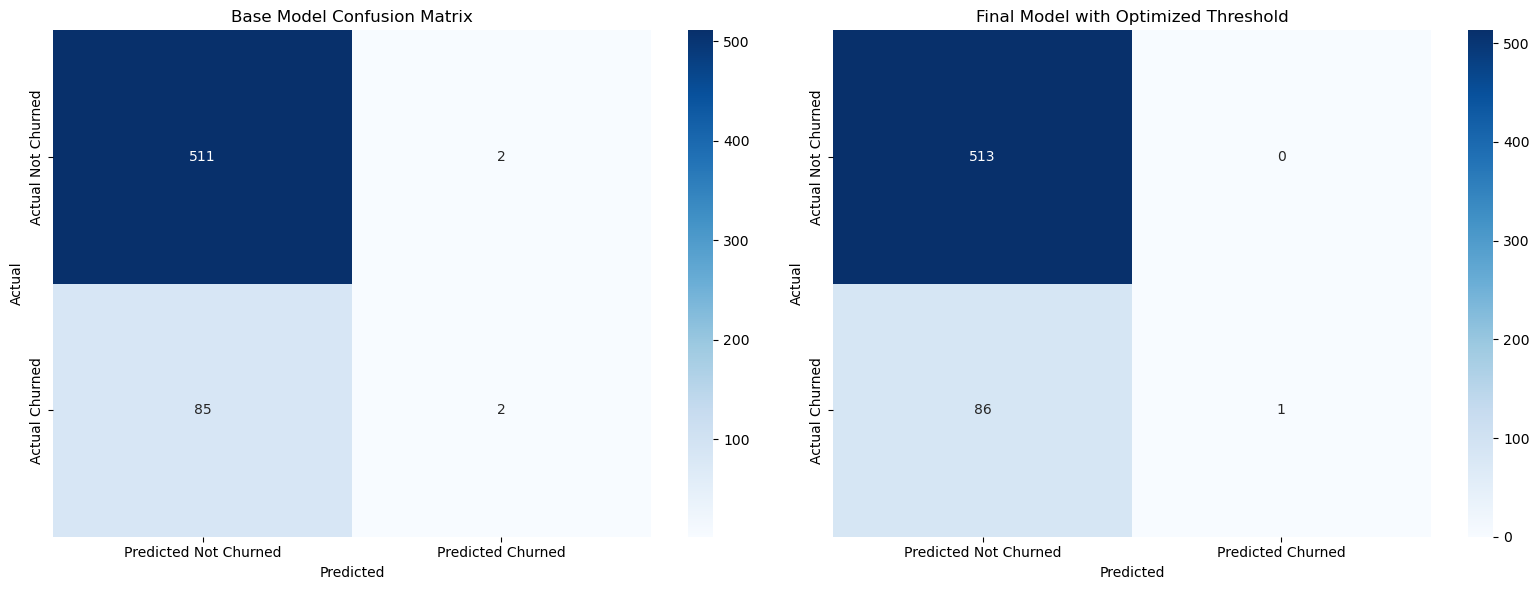

Base Model - Recall: 0.02, Accuracy: 0.85
Final Model - Recall: 0.01, Accuracy: 0.86


In [32]:
from sklearn.metrics import precision_score, recall_score

# Show confusion matrix of base model and final model next to each other
plt.figure(figsize=(16, 6))
conf_matrix_df
# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot confusion matrix of base model (left)
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_title('Base Model Confusion Matrix')
axs[0].set_ylabel('Actual')
axs[0].set_xlabel('Predicted')

# Plot confusion matrix of final model (right)
sns.heatmap(final_conf_matrix_df, annot=True, fmt='d', cmap='Blues', ax=axs[1])
axs[1].set_title('Final Model with Optimized Threshold')
axs[1].set_ylabel('Actual')
axs[1].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

# Calculate accuracy and recall for the final model with optimized threshold using recall_score and accuracy_score which have already been imported
final_recall = recall_score(final_pred_df['Actual_Churn'], final_pred_df['Predicted_Churn'])
final_accuracy = accuracy_score(final_pred_df['Actual_Churn'], final_pred_df['Predicted_Churn'])

# Print precision, recall and accuracy of both models
print(f"Base Model - Recall: {recall:.2f}, Accuracy: {accuracy:.2f}")
print(f"Final Model - Recall: {final_recall:.2f}, Accuracy: {final_accuracy:.2f}")

The final model has a bit higher accuracy, however, it is even worse at predicting churn correctly. Therefore, we will now use a random forest with XGBoost in the hopes of creating a better model

#### Model 2: XGBoost

This model is chosen because while it is not as interpretable as a logistic regression, XGBoost is highly relevant for customer churn prediction because of its ability to handle structured data, detect complex nonlinear patterns, and deal with imbalanced datasets. Additionally, it has regularization capabilities and the importance of each feature can be determined to get an insight into why the model performs the way it does.

##### Step 1: Feature Selection

In [33]:
# For this model, we leave in all features, including the state, to give the model the best possible chance of predicting churn well.
# Transform state column into dummy variables
model2_df = pd.get_dummies(df, columns=['State'], drop_first=True)

# Create binary variables for categorical columns (International plan, voice mail plan, and state)
model2_df['International plan'] = model2_df['International plan'].map({'Yes': 1, 'No': 0})
model2_df['Voice mail plan'] = model2_df['Voice mail plan'].map({'Yes': 1, 'No': 0})
model2_df.head()

,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,...,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY
0,64,408,0,0,0,261.9,113,44.52,148.1,99,...,False,False,False,False,False,False,False,False,False,False
1,139,510,1,1,31,203.5,82,34.60,200.3,72,...,False,False,True,False,False,False,False,False,False,False
2,93,510,0,0,0,190.7,114,32.42,218.2,111,...,False,False,False,False,False,True,False,False,False,False
3,136,415,0,0,0,163.4,83,27.78,249.3,119,...,False,False,False,False,False,False,False,False,False,False
4,16,415,1,0,0,110.0,91,18.70,147.3,75,...,False,False,False,False,False,False,False,False,False,False


In [34]:
# We will also not drop the columns that are perfectly linearly correlated because a random forest can better handle multicollinearity

In [35]:
# Also, again change Churn column from boolean to int with Churn = False as 0 and Churn = True as 1
model2_df['Churn'] = model2_df['Churn'].astype(int)
model2_df.head()

,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,...,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY
0,64,408,0,0,0,261.9,113,44.52,148.1,99,...,False,False,False,False,False,False,False,False,False,False
1,139,510,1,1,31,203.5,82,34.60,200.3,72,...,False,False,True,False,False,False,False,False,False,False
2,93,510,0,0,0,190.7,114,32.42,218.2,111,...,False,False,False,False,False,True,False,False,False,False
3,136,415,0,0,0,163.4,83,27.78,249.3,119,...,False,False,False,False,False,False,False,False,False,False
4,16,415,1,0,0,110.0,91,18.70,147.3,75,...,False,False,False,False,False,False,False,False,False,False


In [36]:
# Finally, for this model we will add additional features
# Add total charge column
model2_df['Total charge'] = model2_df['Total day charge'] + model2_df['Total eve charge'] + model2_df['Total night charge'] + model2_df['Total intl charge']

# Add total minutes column
model2_df['Total minutes'] = model2_df['Total day minutes'] + model2_df['Total eve minutes'] + model2_df['Total night minutes'] + model2_df['Total intl minutes']

# Add total calls column
model2_df['Total calls'] = model2_df['Total day calls'] + model2_df['Total eve calls'] + model2_df['Total night calls'] + model2_df['Total intl calls']

# Add average call duration
model2_df['Average call duration'] = model2_df['Total minutes'] / model2_df['Total calls']

# Add Average Charge per Call
model2_df['Average charge per call'] = model2_df['Total charge'] / model2_df['Total calls']
model2_df.head()

,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,...,State_VT,State_WA,State_WI,State_WV,State_WY,Total charge,Total minutes,Total calls,Average call duration,Average charge per call
0,64,408,0,0,0,261.9,113,44.52,148.1,99,...,False,False,False,False,False,67.37,569.0,290,1.962069,0.232310
1,139,510,1,1,31,203.5,82,34.60,200.3,72,...,False,False,False,False,False,64.88,631.2,272,2.320588,0.238529
2,93,510,0,0,0,190.7,114,32.42,218.2,111,...,True,False,False,False,False,58.99,546.6,349,1.566189,0.169026
3,136,415,0,0,0,163.4,83,27.78,249.3,119,...,False,False,False,False,False,62.86,672.2,296,2.270946,0.212365
4,16,415,1,0,0,110.0,91,18.70,147.3,75,...,False,False,False,False,False,41.52,454.2,246,1.846341,0.168780


##### Step 2: Train-test split

In [37]:
# Use same train-test split as before
X_2 = model2_df.drop(['Churn'], axis=1)  # Features
y_2 = model2_df['Churn']  # Target variable

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=41, stratify=y_2)

# Check the shapes of the train and test sets
print(f"X_train_2 shape: {X_train_2.shape}")
print(f"X_test_2 shape: {X_test_2.shape}")
print(f"y_train_2 shape: {y_train_2.shape}")
print(f"y_test_2 shape: {y_test_2.shape}")

# Check the distribution of the target variable in train and test sets to ensure that stratify=y worked
print(f"Churn rate in training set: {y_train.mean() * 100:.2f}%")
print(f"Churn rate in test set: {y_test.mean() * 100:.2f}%")

X_train_2 shape: (2399, 73)
X_test_2 shape: (600, 73)
y_train_2 shape: (2399,)
y_test_2 shape: (600,)
Churn rate in training set: 14.51%
Churn rate in test set: 14.50%


##### Step 3: Hyperparameter tuning

In [38]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier

# Create a pipeline that applies SMOTE bc of class imbalance and then trains a decision tree classifier
# The pipeline will be used to fit the model to the training data
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('xgb', XGBClassifier(random_state=42))
])

In [39]:
# Set up the hyperparameter grid for the decision tree classifier

param_grid = {
    'xgb__base_score': [0.5],         # Initial prediction score for all instances, lower values predict less churn
    'xgb__booster': ['gbtree'],  # Algorithm to use - tree-based, linear model
    'xgb__colsample_bylevel': [1.0],        # Subsample ratio of columns for each level within a tree
    'xgb__colsample_bytree': [1.0],         # Subsample ratio of columns when constructing each tree
    'xgb__gamma': [0, 0.1],            # Minimum loss reduction required for further partition on a leaf node
    'xgb__n_estimators': [75, 100],   # Number of trees to build (more trees = better performance but slower)
    'xgb__max_depth': [5, 10],    # Maximum depth of a tree (controls complexity)
    'xgb__learning_rate': [0.9, 0.1],   # Step size shrinkage to prevent overfitting
    'xgb__min_child_weight': [1, 2],        # Minimum sum of instance weight needed in a child
    'xgb__objective': ['binary:logistic'],   # Defines the loss function (binary classification with logistic)
    'xgb__random_state': [42],              # Random number seed for reproducibility
    'xgb__reg_alpha': [0, 0.1],        # L1 regularization on weights (prevents overfitting)
    'xgb__reg_lambda': [1, 2],           # L2 regularization on weights (prevents overfitting)
    'xgb__subsample': [1]                   # Subsample ratio of training instances (1 = use all samples)
}

In [40]:
from sklearn.model_selection import GridSearchCV

# Set up stratified 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up the grid search with the pipeline, parameter grid, and cross-validation
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv,
    scoring='accuracy',  # Use accuracy as the scoring metric
    n_jobs=1,  # Use one CPU core
    verbose=2,  # Provide detailed output
)

# Fit the grid search to the training data
grid_search.fit(X_train_2, y_train_2)

Fitting 5 folds for each of 128 candidates, totalling 640 fits
[CV] END xgb__base_score=0.5, xgb__booster=gbtree, xgb__colsample_bylevel=1.0, xgb__colsample_bytree=1.0, xgb__gamma=0, xgb__learning_rate=0.9, xgb__max_depth=5, xgb__min_child_weight=1, xgb__n_estimators=75, xgb__objective=binary:logistic, xgb__random_state=42, xgb__reg_alpha=0, xgb__reg_lambda=1, xgb__subsample=1; total time=   0.1s
[CV] END xgb__base_score=0.5, xgb__booster=gbtree, xgb__colsample_bylevel=1.0, xgb__colsample_bytree=1.0, xgb__gamma=0, xgb__learning_rate=0.9, xgb__max_depth=5, xgb__min_child_weight=1, xgb__n_estimators=75, xgb__objective=binary:logistic, xgb__random_state=42, xgb__reg_alpha=0, xgb__reg_lambda=1, xgb__subsample=1; total time=   0.0s
[CV] END xgb__base_score=0.5, xgb__booster=gbtree, xgb__colsample_bylevel=1.0, xgb__colsample_bytree=1.0, xgb__gamma=0, xgb__learning_rate=0.9, xgb__max_depth=5, xgb__min_child_weight=1, xgb__n_estimators=75, xgb__objective=binary:logistic, xgb__random_state=42, 

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      featu...
                         'xgb__colsample_bylevel': [1.0],
                         'xgb__colsample_bytree': [1.0], 'xgb__gamma': [0, 0.1],
                         'xgb__learning_rate': [0.9, 0.1],
                         'xgb__max_depth': [5, 10],
                         'xgb__min_child_weight': [1, 2],
                         'xgb__n_estimators': [75, 100],
                         'xgb__objective': ['binary:logistic'],
                         'xgb__random_state': [42], 'xgb__reg_alpha': [0, 0.1],
                         'xgb__reg_lambda': [1, 2], 'xgb__subsample': [1]},
             scoring='accuracy', verbose=2)

In [41]:
# Output best parameters and cross-validation accuracy
print("Best Hyperparameters:", grid_search.best_params_)
print("Best CV Accuracy: {:.2f}%".format(grid_search.best_score_*100))

Best Hyperparameters: {'xgb__base_score': 0.5, 'xgb__booster': 'gbtree', 'xgb__colsample_bylevel': 1.0, 'xgb__colsample_bytree': 1.0, 'xgb__gamma': 0.1, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__min_child_weight': 2, 'xgb__n_estimators': 75, 'xgb__objective': 'binary:logistic', 'xgb__random_state': 42, 'xgb__reg_alpha': 0, 'xgb__reg_lambda': 1, 'xgb__subsample': 1}
Best CV Accuracy: 97.00%


##### Step 4: Evaluating the Model

In [42]:
# Evaluate on the test set using the best found model
best_model = grid_search.best_estimator_
y_pred_2 = best_model.predict(X_test_2)

# Calculate the accuracy of the model on the test set
accuracy_2 = accuracy_score(y_test_2, y_pred_2)
print(f"Accuracy of the XGBoost model: {accuracy_2 * 100:.2f}%")

# Also calculate the recall of the model on the test set because when predicting churn, we want to minimize false negatives
recall_2 = recall_score(y_test_2, y_pred_2)
print(f"Recall of the XGBoost model: {recall_2 * 100:.2f}%")

Accuracy of the XGBoost model: 97.00%
Recall of the XGBoost model: 83.91%


In [43]:
# Show some examples of correct predictions including the actual and predicted churn values
# Create a DataFrame with test data and add columns for actual and predicted values plus their percentage certainties
correct_pred_df_2 = X_test_2.copy()

correct_pred_df_2['Actual_Churn'] = y_test_2
correct_pred_df_2['Predicted_Churn'] = y_pred_2

# Filter for correct predictions
correct_pred_df_2 = correct_pred_df_2[correct_pred_df_2['Actual_Churn'] == correct_pred_df_2['Predicted_Churn']]

# Print nr of correct predictions
print(f"Number of correct predictions: {correct_pred_df_2.shape[0]}")
print(f"Percentage of correct predictions: {correct_pred_df_2.shape[0] / len(y_test_2) * 100:.2f}%")

# Display a few examples of correct predictions
print("\nExamples of correct predictions:")
correct_pred_df_2.tail(10)

Number of correct predictions: 582
Percentage of correct predictions: 97.00%

Examples of correct predictions:


,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,...,State_WI,State_WV,State_WY,Total charge,Total minutes,Total calls,Average call duration,Average charge per call,Actual_Churn,Predicted_Churn
1776,132,510,0,0,0,163.2,80,27.74,167.6,90,...,False,False,False,47.60,424.5,270,1.572222,0.176296,0,0
490,119,415,0,0,0,159.1,114,27.05,231.3,117,...,False,False,False,55.53,542.4,325,1.668923,0.170862,1,1
2372,102,408,0,0,0,174.5,73,29.67,213.7,114,...,False,False,False,58.02,563.2,308,1.828571,0.188377,0,0
1125,103,415,0,0,0,158.7,90,26.98,198.4,117,...,False,False,False,54.83,548.7,287,1.911847,0.191045,0,0
2400,68,510,0,0,0,143.6,80,24.41,134.3,65,...,False,False,False,49.72,509.0,234,2.175214,0.212479,0,0
215,71,415,0,0,0,207.0,112,35.19,173.8,96,...,False,False,False,61.26,571.3,272,2.100368,0.225221,0,0
346,115,510,1,0,0,345.3,81,58.70,203.4,106,...,False,False,False,88.97,778.0,302,2.576159,0.294603,1,1
868,74,415,0,0,0,221.1,124,37.59,110.8,94,...,False,False,False,60.67,582.6,333,1.749550,0.182192,0,0
2321,79,415,0,0,0,268.3,114,45.61,185.5,111,...,False,False,False,74.99,724.7,320,2.264687,0.234344,1,1
2697,107,415,0,1,38,204.2,57,34.71,205.9,92,...,False,False,False,67.34,704.9,233,3.025322,0.289013,0,0


In [44]:
# Show some examples of incorrect predictions including the actual and predicted churn values
# Create a DataFrame with test data and add columns for actual and predicted values
incorrect_pred_df_2 = X_test_2.copy()
incorrect_pred_df_2['Actual_Churn'] = y_test_2
incorrect_pred_df_2['Predicted_Churn'] = y_pred_2

# Filter for incorrect predictions
incorrect_pred_df_2 = incorrect_pred_df_2[incorrect_pred_df_2['Actual_Churn'] != incorrect_pred_df_2['Predicted_Churn']]
# Print nr of incorrect predictions
print(f"Number of incorrect predictions: {incorrect_pred_df_2.shape[0]}")
print(f"Percentage of incorrect predictions: {incorrect_pred_df_2.shape[0] / len(y_test_2) * 100:.2f}%")

# Display a few examples of incorrect predictions
print("\nExamples of incorrect predictions:")
incorrect_pred_df_2.head(18)

Number of incorrect predictions: 18
Percentage of incorrect predictions: 3.00%

Examples of incorrect predictions:


,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,...,State_WI,State_WV,State_WY,Total charge,Total minutes,Total calls,Average call duration,Average charge per call,Actual_Churn,Predicted_Churn
707,137,510,0,0,0,110.5,79,18.79,223.2,111,...,False,False,False,48.23,513.7,257,1.998833,0.187665,0,1
2753,121,415,0,0,0,144.8,126,24.62,200.6,82,...,False,False,False,54.66,567.5,298,1.904362,0.183423,1,0
276,101,415,0,1,36,123.7,125,21.03,172.6,106,...,False,False,False,50.70,585.6,362,1.617680,0.140055,1,0
1488,85,415,0,0,0,236.9,93,40.27,197.7,113,...,False,False,False,74.06,755.1,291,2.594845,0.254502,1,0
223,103,415,0,1,18,149.9,84,25.48,170.9,84,...,False,False,False,50.84,503.8,287,1.755401,0.177143,1,0
2932,159,415,0,0,0,189.1,105,32.15,246.1,147,...,False,False,False,66.77,687.6,363,1.894215,0.183939,1,0
156,120,415,0,0,0,252.1,110,42.86,226.1,103,...,False,False,False,72.81,647.6,299,2.165886,0.243512,0,1
1890,40,408,0,1,31,224.7,69,38.20,134.5,81,...,False,False,False,57.07,487.0,259,1.880309,0.220347,1,0
1396,105,415,0,0,0,226.9,106,38.57,182.2,77,...,False,False,False,66.37,624.6,292,2.139041,0.227295,1,0
742,77,510,0,0,0,233.8,104,39.75,266.5,94,...,False,False,False,74.02,720.6,305,2.362623,0.242689,0,1


In [45]:
# Display confusion matrix for the XGBoost Random Forest Model
# Calculate the confusion matrix
conf_matrix_2 = confusion_matrix(y_test_2, y_pred_2)

# Create a DataFrame to display the confusion matrix
conf_matrix_df_2 = pd.DataFrame(conf_matrix_2, index=['Actual Not Churned', 'Actual Churned'], columns=['Predicted Not Churned', 'Predicted Churned'])

# Display the confusion matrix
conf_matrix_df_2

,Predicted Not Churned,Predicted Churned
Actual Not Churned,509,4
Actual Churned,14,73


##### Step 5: Comparing both models

<Figure size 1600x600 with 0 Axes>

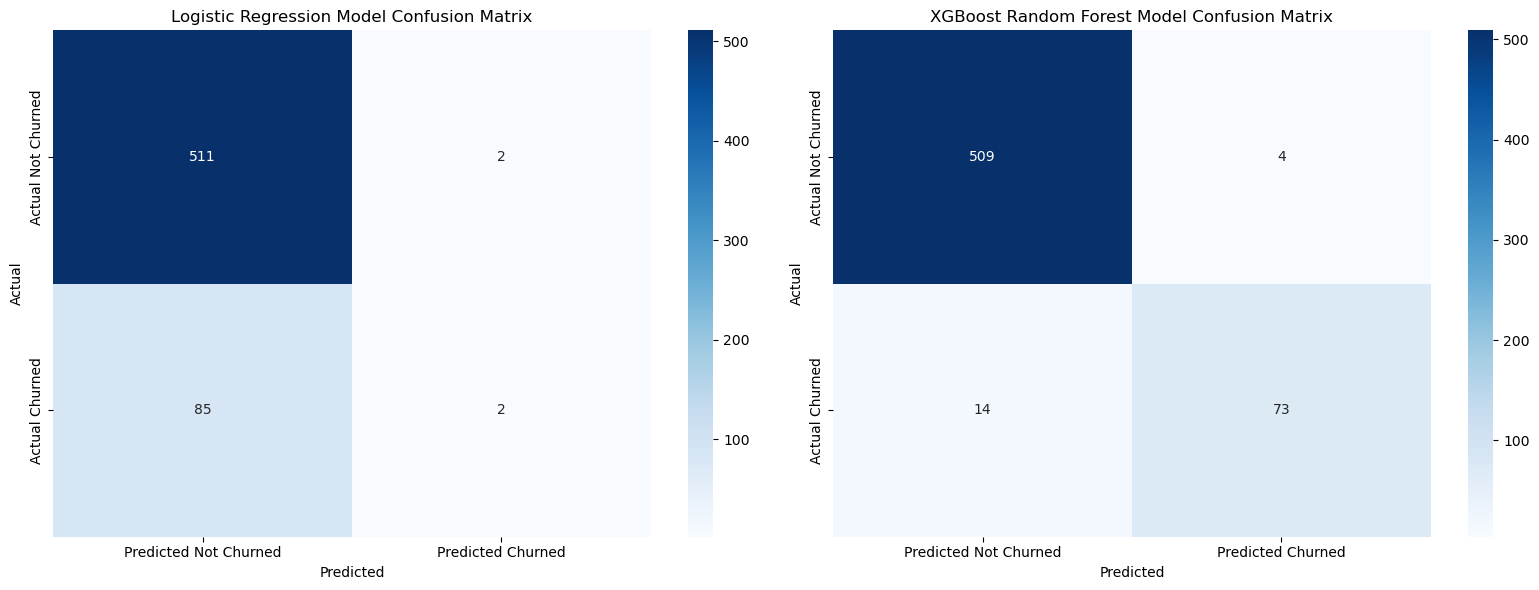

Logistic Regression Model - Recall: 0.02, Accuracy: 0.85
XGBoost Random Forest Model - Recall: 0.84, Accuracy: 0.97


In [46]:
# Comparing the confusion matrices of the logistic regression model and the XGBoost Random Forest model
plt.figure(figsize=(16, 6))
conf_matrix_df
# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot confusion matrix of logistic regression model (left)
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_title('Logistic Regression Model Confusion Matrix')
axs[0].set_ylabel('Actual')
axs[0].set_xlabel('Predicted')

# Plot confusion matrix of XGBoost Random Forest model (right)
sns.heatmap(conf_matrix_df_2, annot=True, fmt='d', cmap='Blues', ax=axs[1])
axs[1].set_title('XGBoost Random Forest Model Confusion Matrix')
axs[1].set_ylabel('Actual')
axs[1].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

# Print precision, recall and accuracy of both models
print(f"Logistic Regression Model - Recall: {recall:.2f}, Accuracy: {accuracy:.2f}")
print(f"XGBoost Random Forest Model - Recall: {recall_2:.2f}, Accuracy: {accuracy_2:.2f}")

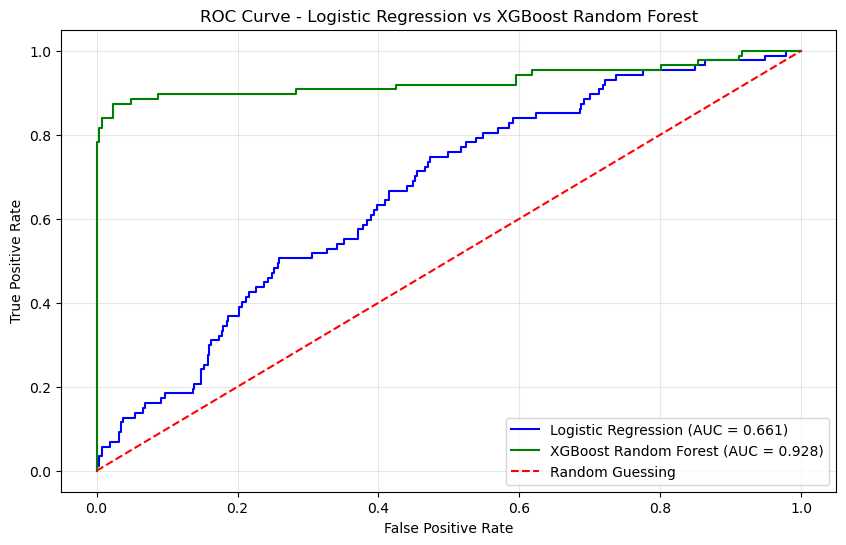

In [47]:
# Comparing the ROC curves of the logistic regression model and the XGBoost Random Forest model
# Calculate the FPR, TPR, and thresholds for the ROC curve
fpr_2, tpr_2, thresholds_2 = roc_curve(y_test_2, best_model.predict_proba(X_test_2)[:, 1])

# Calculate the AUC score
auc_score_2 = roc_auc_score(y_test_2, best_model.predict_proba(X_test_2)[:, 1])

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'Logistic Regression (AUC = {auc_score:.3f})')
plt.plot(fpr_2, tpr_2, color='green', label=f'XGBoost Random Forest (AUC = {auc_score_2:.3f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression vs XGBoost Random Forest')
plt.grid(True, alpha=0.3)
plt.legend(loc='lower right')
plt.show()

The XGBoost model is much better at predicting churned customers than the logistic regression and only marginally worse at predicting non-churners. Therefore, it makes sense to use this model going forward

##### Step 6: Feature Importance

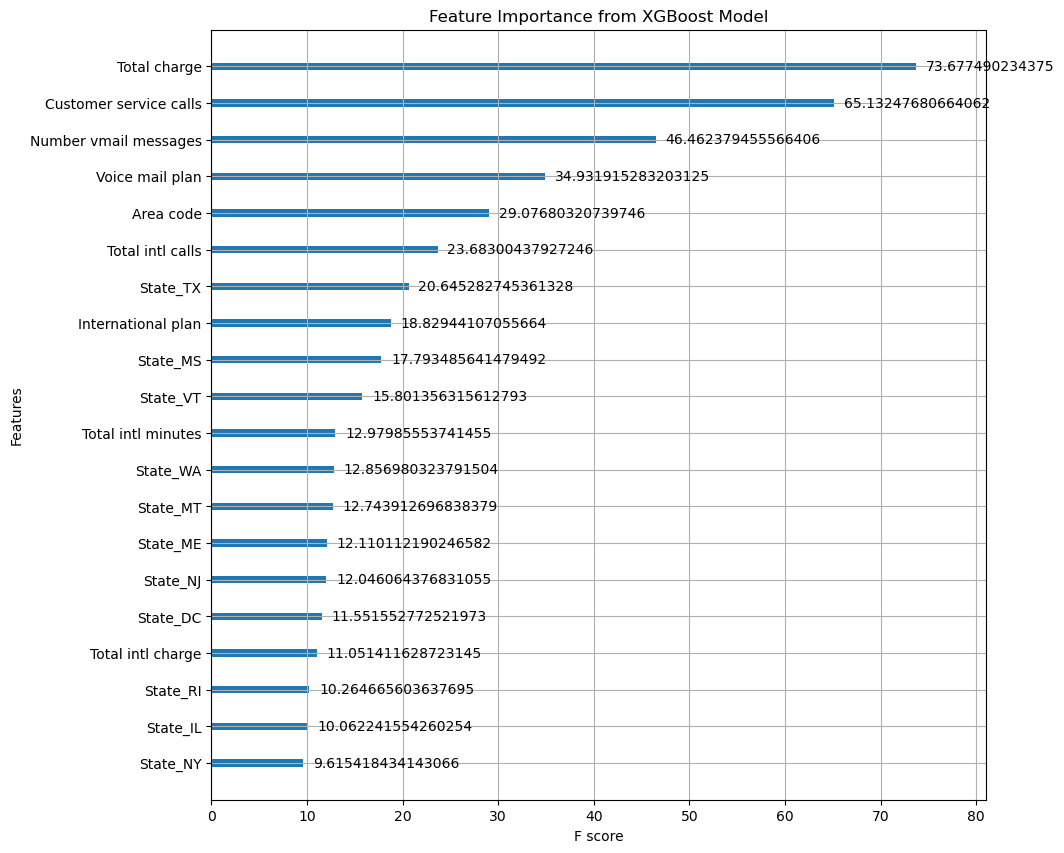

In [48]:
# Looking at plot of feature importance
import xgboost as xgb

# Access the XGBClassifier from the pipeline
xgb_model_classifier = best_model.named_steps['xgb']

# Plot feature importances using xgboost's built-in function
fig, ax = plt.subplots(figsize=(10, 10))
# Gain is used to measure the improvement in accuracy brought by a feature to the branches it is on because 
# accuracy is the main goal of the model
xgb.plot_importance(xgb_model_classifier, importance_type="gain", ax=ax, max_num_features=20)
plt.title('Feature Importance from XGBoost Model')
plt.show()

## Q3 To ensure the predictive models are reliable, the taskforce must evaluate their performance using appropriate metrics. This evaluation will determine which model is best suited for deployment.

### Q3.1 Which performance metric did you use to evaluate the performance? Why? [Free text + code]

I selected accuracy as the performance metric because that is the metric the professor said the models will have their performance graded on. Otherwise, I would have chosen the F-2 score. The F-2 score merges recall and precision into a single score, providing a good blend between how well the model can predict churners well and if it overpredicts non-churners to be churners. Unlike the F-1 score, the F-2 score puts more emphasis on recall than on precision. This makes sense because the telcom company should be more concerned about correctly predicting all possible churning customers (recall) than predicting too many non-churning customers to be churners (precision) because a churned customer likely costs the company a lot more than being overcareful with a non-churning customer. On the other hand, just focusing entirely on recall will incentivize the model just to predict all customers as churners which is not ideal because it will involve a lot of unnecessary effort on the part of the telcom company to keep customers happy that are not planning on leaving in the first place. Therefore, the F-2 score provides a very good balance and makes most sense to me as a performance metric.

### Q3.2 Which model provided the best results?

As shown previously, the XGBoost model provided the best results both in terms of accuracy and recall when compared to the logistic regression. The ROC curves of both models show that this pattern holds at almost all threshold levels.

## Q4: The executive team has provided an external validation dataset with the same structure as the original data. To test the best model, the team must ensure it works seamlessly on new data. The model should predict churn using binary outputs: 0 (No Churn) and 1 (Churn).

- Save the best-performing model as a Pickle file (StudentNumber_Pipeline.pkl).
Please see the code Assignment1_SaveAsPickle.ipynb with the examples
- To ensure the code runs in every machine please save the requirements files with the
name StudentNumber_requirements.txt – please see
Assignment1_SaveAsPickle.ipynb on how to do it.
    - For this to happen you will also require submitting a .py file with your feature
engineer function, please keep the following name feature_engineering.py
- If you are using a model outside the scikit-learn you will need to save the following
files:
    - StudentNumber_Preprocessor.pkl – where the preprocessing steps are
performed
    - StudentNumber_Model.pkl - where the model does the prediction task.
- Write code to reload the saved model and test it on the external validation dataset
(please see Assignment1_SaveAsPickle.ipynb on how to do it. The validation set
will be in the format from the file
2767ML_assignment1_externalvalidation_data_toStudents.csv). If your
model runs in this dataset it will run in the final validation set.
- Ensure the model outputs predictions in the required format 0 (No Churn) and 1
(Churn).

How This Question Will Be Evaluated:
1. Top 25% Models: The models that perform the best on the external validation dataset
will receive full marks for this task. Performance will be ranked based on accuracy.
2. Next 25% Models: Students whose models perform in the following 25% will have 3
and so on.
3. Non-Functional Models: If your model fails to load, run, or provide predictions in the
required format (0 for No Churn, 1 for Churn), you will receive zero marks for this
task. Make sure your .pkl file and code are functional, tested, and well-documented.
    1. You can find a test set in the assignment on moodle with the same format
as the final (2767ML_assignment1_externalvalidation_data_toStudents.csv).

### Step 1: Saving the model

In [49]:
# Load initial dataset
df = pd.read_csv('2767ML_assignment1_data.csv')

# Identify numerical and categorical columns
df.dtypes

State                      object
Account length              int64
Area code                   int64
International plan         object
Voice mail plan            object
Number vmail messages       int64
Total day minutes         float64
Total day calls             int64
Total day charge          float64
Total eve minutes         float64
Total eve calls             int64
Total eve charge          float64
Total night minutes       float64
Total night calls           int64
Total night charge        float64
Total intl minutes        float64
Total intl calls            int64
Total intl charge         float64
Customer service calls      int64
Churn                        bool
dtype: object

In [50]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import pickle

# Save numerical columns to a list
numerical_columns = ['Account length', 'Area code', 'Number vmail messages', 'Total day minutes', 'Total day calls', 'Total day charge', 'Total eve minutes', 'Total eve calls', 'Total eve charge', 'Total night minutes', 'Total night calls', 'Total night charge', 'Total intl minutes', 'Total intl calls', 'Total intl charge', 'Customer service calls']

# Save categorical columns to a list
categorical_columns = ['State', 'International plan', 'Voice mail plan']

# Convert Churn from boolean to integer (0 for False, 1 for True)
df['Churn'] = df['Churn'].astype(int)

# Split the data into features and target variable
X_save = df.drop('Churn', axis=1)
Y_save = df['Churn']

# Define function to perform feature selection steps
def feature_engineering(X_save):
    # Add total charge column
    X_save['Total charge'] = X_save['Total day charge'] + X_save['Total eve charge'] + X_save['Total night charge'] + X_save['Total intl charge']
    # Add total minutes column
    X_save['Total minutes'] = X_save['Total day minutes'] + X_save['Total eve minutes'] + X_save['Total night minutes'] + X_save['Total intl minutes']
    # Add total calls column
    X_save['Total calls'] = X_save['Total day calls'] + X_save['Total eve calls'] + X_save['Total night calls'] + X_save['Total intl calls']
    # Add average call duration
    X_save['Average call duration'] = X_save['Total minutes'] / X_save['Total calls']
    # Add Average Charge per Call
    X_save['Average charge per call'] = X_save['Total charge'] / X_save['Total calls']

    return X_save

# Apply FunctionTransformer to apply the feature engineering function
feature_transformer = FunctionTransformer(feature_engineering)

# Handle NaN values in the dataset
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Replace NaN with median
    ('scaler', StandardScaler())  # Scale the numerical data
])

# Handle categorical values in the dataset
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)),  # Replace NaN with 'missing'
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode the categorical data
])

# 3 Combine both transformations into a ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_columns),
    ('cat', categorical_transformer, categorical_columns)
])

# Create the full pipeline with preprocessing + feature engineering + model
preprocessing_pipeline = Pipeline([
    ('feature_engineering', feature_transformer), 
    ('preprocessor', preprocessor),
])

# Apply preprocessing transformations
X_transformed = preprocessing_pipeline.fit_transform(X_save)

# Train-test split
X_train_save, X_test_save, Y_train_save, Y_test_save = train_test_split(X_transformed, Y_save, test_size=0.20, random_state=42)

# Train **XGBoost** Model
xgb_model = best_model
xgb_model.fit(X_train_save, Y_train_save)

# Save **Preprocessing + Feature Engineering Together**
with open("preprocessor.pkl", "wb") as file:
    pickle.dump(preprocessing_pipeline, file)

# Save **XGBoost Model** as Pickle
with open("Finn_Hetzler_Model.pkl", "wb") as file:
    pickle.dump(xgb_model, file)  # Saving XGBClassifier using Pickle

print("Preprocessing pipeline (feature engineering + transformations) and XGBoost model saved successfully!")

Preprocessing pipeline (feature engineering + transformations) and XGBoost model saved successfully!


### Step 2: Install the requirements, load the model and apply it

In [51]:
!pip freeze > requirements.txt

In [52]:
from feature_engineering import feature_engineering
import pickle
import pandas as pd

# Load the preprocessing pipeline (including feature engineering)
with open("preprocessor.pkl", "rb") as file:
    loaded_preprocessor = pickle.load(file)

# Load the XGBoost model (pickled)
with open("Finn_Hetzler_Model.pkl", "rb") as file:
    xgb_loaded_model = pickle.load(file)

print("Preprocessing pipeline (feature engineering + transformations) and XGBoost model loaded successfully!")

# New data to make a prediction
validation_df = pd.read_csv('2767ML_assignment1_externalvalidation_data_toStudents.csv')
validation_df.head()

# Apply feature engineering and preprocessing together
new_data_transformed = loaded_preprocessor.transform(validation_df)

# Make prediction using the loaded XGBoost model
xgb_prediction = xgb_loaded_model.predict(new_data_transformed)

print(f"XGBoost Prediction: {xgb_prediction[0]}")

Preprocessing pipeline (feature engineering + transformations) and XGBoost model loaded successfully!
XGBoost Prediction: 0


## Q5: The executive team requires actionable insights to guide the strategy to address customer churn effectively. Your analysis will directly inform their decisions

### Q5.1 What customer characteristics most strongly influence churn? [Free text]

The most important features were already shown earlier in the plot in Step 6 of Model 2: [Link](#step-6-feature-importance). Note, I wanted to put the plot down here but for some reason the feature names were not showing

Based on this plot, the most important features are the Total Charge, Customer service calls and Number vmail messages of the customer. It is particularly noteworthy that Total Charge was the most important feature, considering all of the features that were summed up to make this feature (Total day charge, Total eve charge, Total night charge, Total intl charge) were left in the model and therefore likely take away feature importance from Total Charge.

### Q5.2 What actionable steps should the company take to reduce churn? Suggest two strategies. [Free text]

1. The company should collect feedback from customers the model predicts are likely to churn. By proactively asking these people, for example with a survey, they can address the issues they have with the current service, so the company knows what to change so that they remain customers.

2. As seen above in the 15 most important features, one of the states, namely "WV" or West Virginia is also an important feature. It could also make sense to take a closer look at what customers are unsatisfied with there. For example, if they say network quality is not good, then they can look into improving their network infrastructure. Alternatively, if there is a cheaper competitor, they can look into lowering prices to remain competitive.